In [1]:
# packages used
import pandas as pd
import numpy as np
from sklearn import tree
#from sklearn.ensemble import BaggingClassifier
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
%matplotlib inline

In [2]:
# Load the data
data_dir = 'Data/'
Stores = pd.read_csv(data_dir + 'AllStoresKansas.csv', dtype = str)
StoreType = pd.read_csv(data_dir + 'NonLowPointStoresKansas.csv', dtype = str)

In [3]:
Stores.head()

,RTL_STORE_CD,RTL_FIPS_COUNTY_DSC,RTL_PREMISE_TYPE_CD,RTL_CHANNEL_DSC,RTL_SUBCHANNEL_DSC,RTL_BEER_FLAG,RTL_LIQUOR_FLG
0,101403888,SEDGWICK,OFF,LIQUOR,CONVENTIONAL LIQUOR,Y,Y
1,100091604,SALINE,OFF,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,Y,N
2,200697901,SEDGWICK,OFF,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,Y,N
3,100091143,HARPER,OFF,GROCERY,SUPERMARKET-CONVENTIONAL,Y,N
4,107381463,DOUGLAS,OFF,GROCERY,SUPERMARKET-NATURAL/GOURMET FOODS,Y,N


In [4]:
StoreType.head()

,RTL_STORE_CD,BEERTYPE
0,201919318,NonLowPoint
1,205526360,NonLowPoint
2,100765511,NonLowPoint
3,101868466,NonLowPoint
4,103714116,NonLowPoint


In [5]:
FullData = pd.merge(Stores, StoreType, on="RTL_STORE_CD", how="left")

In [6]:
FullData.loc[FullData['BEERTYPE'].isnull(),"BEERTYPE"] = "LowPoint"

In [7]:
FullData = pd.concat([FullData, pd.get_dummies(FullData['RTL_FIPS_COUNTY_DSC'],prefix='COUNTY')], axis=1)
FullData = pd.concat([FullData, pd.get_dummies(FullData['RTL_PREMISE_TYPE_CD'],prefix='PREMISE')], axis=1)
FullData = pd.concat([FullData, pd.get_dummies(FullData['RTL_CHANNEL_DSC'],prefix='CHANNEL')], axis=1)
FullData = pd.concat([FullData, pd.get_dummies(FullData['RTL_SUBCHANNEL_DSC'],prefix='SUBCHANNEL')], axis=1)
FullData = pd.concat([FullData, pd.get_dummies(FullData['RTL_BEER_FLAG'],prefix='BEER_LICENSE')], axis=1)
FullData = pd.concat([FullData, pd.get_dummies(FullData['RTL_LIQUOR_FLG'],prefix='LIQUOR_LICENSE')], axis=1)
FullData.head()

,RTL_STORE_CD,RTL_FIPS_COUNTY_DSC,RTL_PREMISE_TYPE_CD,RTL_CHANNEL_DSC,RTL_SUBCHANNEL_DSC,RTL_BEER_FLAG,RTL_LIQUOR_FLG,BEERTYPE,COUNTY_ALLEN,COUNTY_ANDERSON,...,SUBCHANNEL_SUPERMARKET-NATURAL/GOURMET FOODS,SUBCHANNEL_THEATER,SUBCHANNEL_UNKNOWN,SUBCHANNEL_WINE SPECIALTY STORE,BEER_LICENSE_N,BEER_LICENSE_U,BEER_LICENSE_Y,LIQUOR_LICENSE_N,LIQUOR_LICENSE_U,LIQUOR_LICENSE_Y
0,101403888,SEDGWICK,OFF,LIQUOR,CONVENTIONAL LIQUOR,Y,Y,NonLowPoint,0,0,...,0,0,0,0,0,0,1,0,0,1
1,100091604,SALINE,OFF,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,Y,N,LowPoint,0,0,...,0,0,0,0,0,0,1,1,0,0
2,200697901,SEDGWICK,OFF,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,Y,N,LowPoint,0,0,...,0,0,0,0,0,0,1,1,0,0
3,100091143,HARPER,OFF,GROCERY,SUPERMARKET-CONVENTIONAL,Y,N,LowPoint,0,0,...,0,0,0,0,0,0,1,1,0,0
4,107381463,DOUGLAS,OFF,GROCERY,SUPERMARKET-NATURAL/GOURMET FOODS,Y,N,LowPoint,0,0,...,1,0,0,0,0,0,1,1,0,0


In [8]:
### Prepare Data

In [9]:
# prepare data to fit model
X_labels = [c for c in FullData.columns if c not in ['RTL_STORE_CD','BEERTYPE','RTL_FIPS_COUNTY_DSC','RTL_PREMISE_TYPE_CD','RTL_CHANNEL_DSC','RTL_SUBCHANNEL_DSC','RTL_BEER_FLAG',"RTL_LIQUOR_FLG"]]
X = FullData.loc[:,X_labels]
Y = FullData['BEERTYPE']

# split data to training and test data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)

In [10]:
clf = tree.DecisionTreeClassifier(min_samples_split = 10)
clf = clf.fit(X_train,Y_train)

In [11]:
clf.score(X_test, Y_test)

0.94876660341555974

In [15]:
# change the parameter depth and compute test error
results = []
for d in range(1,15):
    clf = tree.DecisionTreeClassifier(max_depth=d, min_samples_split = 10)
    clf = clf.fit(X,Y)    
    scores = cross_val_score(clf, X, Y, cv=5)
    results.append((d,scores.mean(), scores.std()))
    
df_tree_accuracy = pd.DataFrame(data=results,columns=['depth','mean','std'])
df_tree_accuracy

,depth,mean,std
0,1,0.919923,0.013971
1,2,0.918784,0.013398
2,3,0.920301,0.014616
3,4,0.921440,0.013251
4,5,0.930933,0.005915
5,6,0.941558,0.009981
6,7,0.941558,0.011139
7,8,0.944973,0.012288
8,9,0.947249,0.012317
9,10,0.950284,0.008610


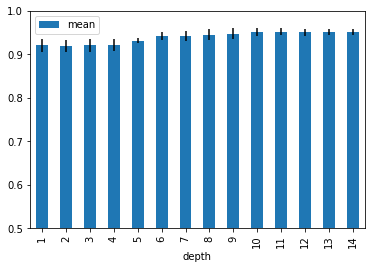

In [16]:
df_tree_accuracy.plot.bar(x='depth',y='mean',yerr='std', ylim=[0.5,1])

In [17]:
pd.Series(data=clf.feature_importances_, index=X.columns).sort_values(ascending = False)

LIQUOR_LICENSE_Y                       0.785286
CHANNEL_LIQUOR                         0.036956
COUNTY_DOUGLAS                         0.025216
COUNTY_SHAWNEE                         0.019377
COUNTY_JOHNSON                         0.017396
COUNTY_SEDGWICK                        0.012210
SUBCHANNEL_CASUAL DINING               0.009881
COUNTY_RILEY                           0.008442
COUNTY_WYANDOTTE                       0.006579
COUNTY_LEAVENWORTH                     0.006468
COUNTY_BUTLER                          0.005581
PREMISE_OFF                            0.005451
COUNTY_RENO                            0.005370
PREMISE_NR                             0.004976
SUBCHANNEL_FAST CASUAL                 0.004571
BEER_LICENSE_N                         0.003967
SUBCHANNEL_THEATER                     0.003129
CHANNEL_MILITARY ON-PREMISE            0.002705
COUNTY_COWLEY                          0.002595
SUBCHANNEL_OFFICE BUILDING             0.002042
CHANNEL_GROCERY                        0